In [1]:
! pip install -q -r requirements.txt

In [2]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = 'true'

os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com'

os.environ["LANGCHAIN_API_KEY"] = os.getenv('COHERE_ADAPTIVE_RAG')

os.environ["LANGCHAIN_PROJECT"] = 'COHERE_ADAPTIVE_RAG'

os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

os.environ["GOOGLE_API_KEY"] = os.getenv('GEMINI_API_KEY')

os.environ['USER_AGENT'] = 'myagent'

os.environ['COHERE_API_KEY'] = os.getenv('COHERE_API_KEY')


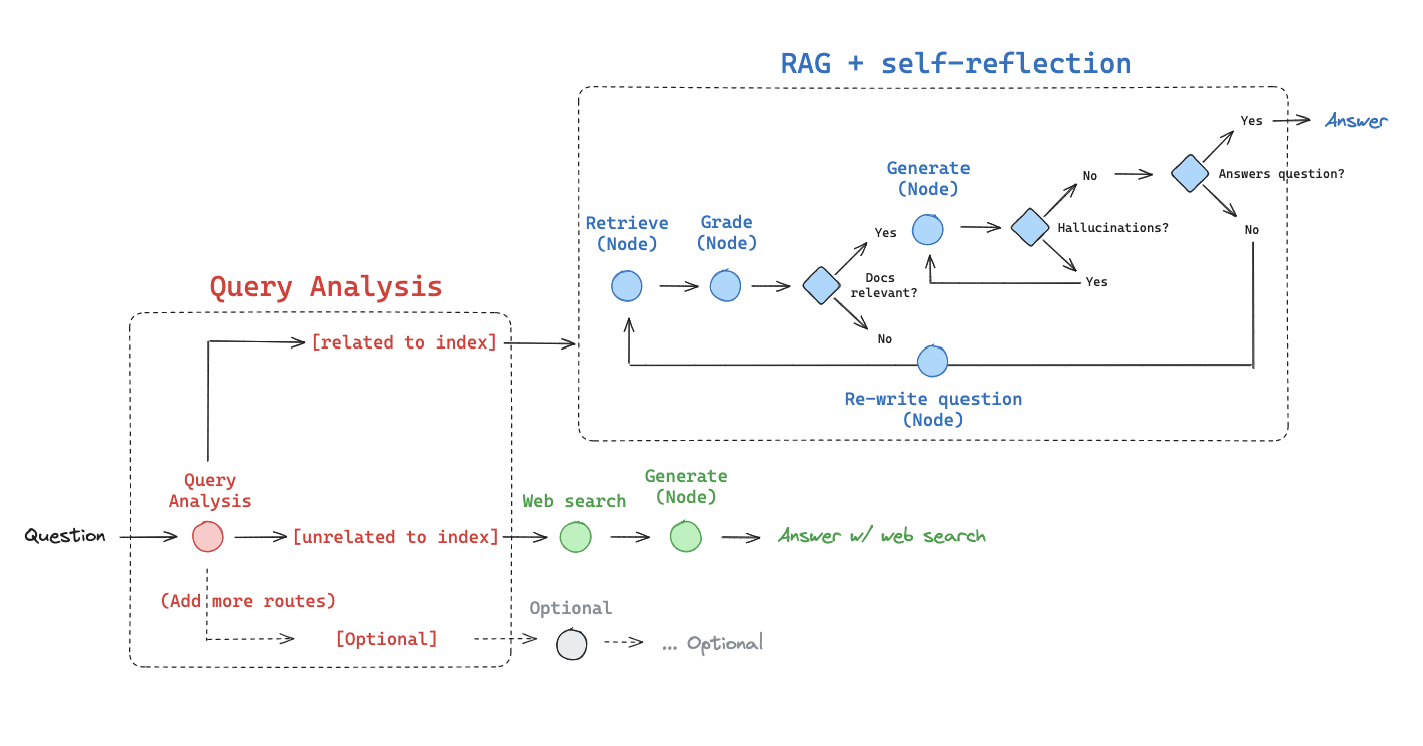

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_cohere import CohereEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Set embeddings
# embd = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=os.getenv("GEMINI_API_KEY"))
embd = CohereEmbeddings(model="embed-english-v3.0")

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(urls).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512,
    chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vector store
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embd
)

retriever = vectorstore.as_retriever()

In [4]:
retriever.invoke("agent memory")

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n

In [16]:
### Router
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_cohere import ChatCohere

# Data model
class web_search(BaseModel):
  """
  The internet, Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
  """
  query: str = Field(description="The query to use when searching the internet.")

class vectorstore(BaseModel):
  """
  A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions on this topic.
  """

  query: str = Field(description="The query to use when searching the vectorstore.")

# Preamble
preamble = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstores contain documents related to agents, prompt engineering and adversarial attacks,
Use the vectorstore for questions on this topic. Otherwise, use web-search."""

# LLM with tool use and preamble
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_router = llm.bind_tools(
    tools=[web_search, vectorstore],
    preamble=preamble
)

# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}")
    ]
)

# Test
question_router = route_prompt | structured_llm_router
response = question_router.invoke({"question": "Who will the bears draft first in the NFL drafts"})
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "What are the types of agent memory"})
print(response.response_metadata['tool_calls'])
response = question_router.invoke({"question": "Hi how are you!"})
print('tool_calls' in response.response_metadata)

content='' additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "Who will the bears draft first in the NFL drafts"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-17aeb76e-d77f-4089-8709-3fb6c67dd6c5-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'Who will the bears draft first in the NFL drafts'}, 'id': '806d0fcb-ba6a-4cb0-993f-9a5e29c2a71d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 125, 'output_tokens': 24, 'total_tokens': 149}


In [6]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# Prompt
preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader =  llm.with_structured_output(GradeDocuments, preamble=preamble)

# Prompt
grade_prompt =  ChatPromptTemplate.from_messages(
    [
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "types of agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

{'binary_score': 'yes'}


In [7]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
import langchain
from langchain_core.messages import HumanMessage

# Preamble
preamble = """You are an assistant for question answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# LLM
llm = ChatCohere(model="command-r", temperature=0).bind(preamble=preamble)

# Prompt
prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: ",
            additional_kwargs={"documents": x["documents"]}
        )
    ]
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

There are three types of agent memory: sensory memory, short-term memory (or working memory), and long-term memory. Sensory memory lasts for a few seconds and processes impressions of sensory information. Short-term memory also lasts for around 30 seconds and is needed for complex cognitive tasks like learning and reasoning. Long-term memory has an unlimited storage capacity and can store information for very long periods.


In [8]:
### LLM fallback

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
import langchain
from langchain_core.messages import HumanMessage

# Preamble
preamble = """You are an assistant for question answering tasks. Answer the question based on your knowledge. Use three sentences maximum and keep the answer concise."""

# LLM
llm = ChatCohere(model="command-r", temperature=0).bind(preamble=preamble)

# Prompt
prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f"Question: {x['question']} \nAnswer: "
        )
    ]
)

# Chain
llm_chain = prompt | llm | StrOutputParser()

# Run
question = "Hi how are you?"
generation = llm_chain.invoke({"question": question})
print(generation)

Hello! I'm doing well, thank you for asking. As an AI chatbot, I respond to questions and requests with helpful and relevant information. How can I assist you today?


In [9]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
  """Binary score for hallucination present in generation answer."""

  binary_score: str = Field(description="Answer is grounded in the fact, 'yes' or 'no'")

# Prompt
preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no','Yes' means that the answer is grounded in /supported by the set of facts"""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader =  llm.with_structured_output(GradeHallucinations, preamble=preamble)

# Prompt
hallucination_prompt =  ChatPromptTemplate.from_messages(
    [
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'binary_score': 'yes'}

In [18]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
  """Binary score to assess answer addresses question."""

  binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# Prompt
preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no','Yes' means that the answer resolves the question"""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader =  llm.with_structured_output(GradeAnswer, preamble=preamble)

# Prompt
answer_prompt =  ChatPromptTemplate.from_messages(
    [
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='')

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

In [12]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
  """
  question: str
  generation: str
  documents: List[str]

from langchain.schema import Document

def retrieve(state):
  """
  Rerieve documents

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contain retrieved documents
  """
  print("----RETRIEVE----")
  question = state["question"]

  # Retrieval
  documents = retriever.invoke(question)
  return {"documents": documents, "question": question}

def llm_fallback(state):
  """
  Generate answer using the LLM w/o vectorstore

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """

  print("----LLM Fallback----")
  question = state["question"]
  generation = llm_chain.invoke({"question": question})
  return {"question": question, "generation": generation}

def generate(state):
  """
  Generate answer using the vectorstore

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """
  print("----GENERATE----")
  question = state["question"]
  documents = state["documents"]
  if not isinstance(documents, list):
    documents = [documents]

  # RAG generation
  generation = rag_chain.invoke({"documents": documents, "question": question})
  return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
  """
  Determines whether the retrieved documents are relevant to the question

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """
  print("----CHECK DOCUMENT RELEVANCE TO QUESTION----")
  question = state["question"]
  documents = state["documents"]

  # Score each doc
  filtered_docs = []
  for d in documents:
    score = retrieval_grader.invoke({"question": question, "document": d.page_content})
    grade = score["binary_score"]
    if grade == "yes":
      print("----GRADE: DOCUMENT RELEVANT----")
      filtered_docs.append(d)
    else:
      print("----GRADE: DOCUMENT NOT RELEVANT----")
      continue
  return {"documents": filtered_docs, "question": question}

def web_search(state):
  """
  Web search based on the re-phrased question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """
  print("----WEB SEARCH----")
  question = state["question"]

  # Web search
  docs = web_search_tool.invoke({"query": question})
  web_results = "\n".join(d["content"] for d in docs)
  web_results = Document(page_content=web_results)

  return {"documents": web_results, "question": question}


### Edges ###

def route_question(state):
  """
  Route question to web search or RAG

  Args:
    state (dict): The current graph state

  Returns:
    str: Next mode to call
  """

  print("----ROUTE QUESTION----")
  question = state["question"]
  source = question_router.invoke({"question": question})

  # Fallback to LLM or raise error if no decision
  if "tool_calls" not in source.additional_kwargs:
    print("----ROUTE QUESTION TO LLM----")
    return "llm_fallback"
  if len(source.additional_kwargs["tool_calls"]) == 0:
    raise "Router could not decide source"

  # Choose datasource
  datasource = source.additional_kwargs["tool_calls"][0]["function"]["name"]
  if datasource == 'web_search':
    print("----ROUTE QUESTION TO WEB SEARCH----")
    return "web_search"
  elif datasource == 'vectorstore':
    print("----ROUTE QUESTION TO RAG----")
    return "vectorstore"
  else:
    print("----ROUTE QUESTION TO LLM----")
    return "vectorstore"

def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question

  Args:
  state (dict): The current graph state

  Returns:
  str: Binary decision for next node to call
  """
  print("----ASSESS GRADED DOCUMENTS----")
  question = state["question"]
  filtered_documents = state["documents"]

  if not filtered_documents:
    # All documents have been filtered check relevance
    # We will re-generate a new query
    print("----DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH----")
    return "web_search"
  else:
    # We have relevant documents, so generate answer
    print("----DECISION: GENERATE----")
    return "generate"

def grade_generation_v_docuements_and_question(state):
  """
  Determines whether the generation is grounded in the document and answers the question

  Args:
    state (dict): The current graph state

  Returns:
    str: Binary decision for next node to call
  """

  print("----CHECK HALLUCINATIONS----")
  question = state["question"]
  documents = state["documents"]
  generation = state["generation"]

  score = hallucination_grader.invoke({"documents": documents, "generation": generation})
  grade = score["binary_score"]

  # Check hallucination
  if grade == "yes":
    print("----DECISION: GENERATION IS GROUNDED IN DOCUMENTS----")
    # Check question-answering
    print("----GRADE GENERATION vs QUESTION----")
    score = answer_grader.invoke({"question": question, "generation": generation})
    grade = score["binary_score"]
    if grade == "yes":
      print("----DECISION: GENERATION ADDRESSES QUESTION")
      return "useful"
    else:
      print("----DECISION: GENERATION DOES NOT ADDRESS QUESTION----")
      return "not useful"
  else:
    pprint.pprint("----DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY----")
    return "not supported"

In [13]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate
workflow.add_node("llm_fallback", llm_fallback) # llm

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)

workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_docuements_and_question,
    {
        "not supported": "generate", # Hallucinations: re-generate
        "not useful": "web_search", # Fails to answer question: fall-back to web search
        "useful": END
    },
)

workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()

In [3]:
# Run
inputs = {
    "question": "What player are the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
  for key, value in output.items():
    # Node
    pprint.pprint(f"Node '{key}':")
    # Optional: print full state at each node
    # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
  pprint.pprint("\n----\n")

# Final generation
pprint.pprint(value ["generation"])

NameError: name 'app' is not defined

In [20]:
# Run
inputs = {
    "question": "What are the types of agent memory?"
}
for output in app.stream(inputs):
  for key, value in output.items():
    # Node
    pprint.pprint(f"Node '{key}':")
    # Optional: print full state at each node
    # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
  pprint.pprint("\n----\n")

# Final generation
pprint.pprint(value ["generation"])

----ROUTE QUESTION----
----ROUTE QUESTION TO LLM----
----LLM Fallback----
"Node 'llm_fallback':"
'\n----\n'
('There are three main types of memory used in agent systems: episodic, '
 'semantic, and procedural. Episodic memory stores specific events or '
 'experiences, semantic memory holds general knowledge facts, and procedural '
 'memory knows how to perform tasks.')


In [19]:
# Run
inputs = {
    "question": "Hello, how are you today?"
}
for output in app.stream(inputs):
  for key, value in output.items():
    # Node
    pprint.pprint(f"Node '{key}':")
    # Optional: print full state at each node
    # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
  pprint.pprint("\n----\n")

# Final generation
pprint.pprint(value ["generation"])

----ROUTE QUESTION----
----ROUTE QUESTION TO LLM----
----LLM Fallback----
"Node 'llm_fallback':"
'\n----\n'
("Hello! I'm doing well, thank you for asking. As an AI chatbot, I experience "
 "no highs or lows, but I'm always ready to assist you with any questions or "
 'tasks you have in mind. How can I help you today?')


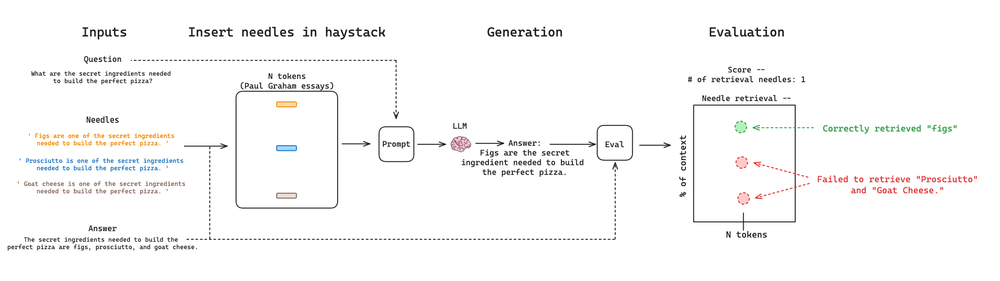